'*I cannot imagine any condition which would cause a ship to founder. I cannot conceive of any vital disaster happening to this vessel. Modern ship building has gone beyond that*'.

~Captain Smith

# Titanic - dataset classification

## Introduction

Sinking of RMS Titanic was one of the biggest and well known maritime tragedy of all the time. In 1912 around 1500 passengers died and only about 730 survived.

Although the exact number of passengers, survivors and victims remains unknown, the Kaggle dataset provides significant amount of data to analyse.

In the following research, the dataset will be analysed to see who has the greatest chances of surviving and machine learning model will be built to predict who could have eventually survived the tragedy.

The dataset with description competition is available on the Kaggle website: https://www.kaggle.com/c/titanic

## Kernel setup

In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import sys

sys.path.append('../')

import warnings
warnings.filterwarnings('ignore')

## Dataset

Dataset provided by Kaggle contains 3 CSV files:

* train.csv - labelled dataset used to train the ML model
* test.csv - dataset without label used to create prediction file
* gender_submission - example submission file

In [2]:
from titanic_classification.load_data import load_data

train_set = load_data('./dataset/', 'train.csv', keep_na=True)
train_set_without_nans = load_data('./dataset/', 'train.csv', keep_na=False)

The number of features is quite limited, in addition some of the columns can be easily ruled-out as will not provide any improvement in the dataset classification - for example ID.

Most columns are self-explaining, but there are few columns that might be a bit more mysterious:

| Name        | Description                                                          |
|-------------|----------------------------------------------------------------------|
| PassangerId | ID of the passenger                                                  |
| Survived    | Boolean value (1 = survived, 0 = died)                               |
| Pclass      | Class of cabin (1 = first, 2 = second, 3 = third)                    |
| Name        | Name of passenger                                                    |
| Sex         | Sex                                                                  |
| Age         | Age                                                                  |
| SibSp       | Number of siblings/spouses aboard on Titanic                         |
| Parch       | Number of parents/children aboard on Titanic                         |
| Ticket      | Ticket number                                                        |
| Cabin       | Cabin number                                                         |
| Embarked    | Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton) |

## Insight

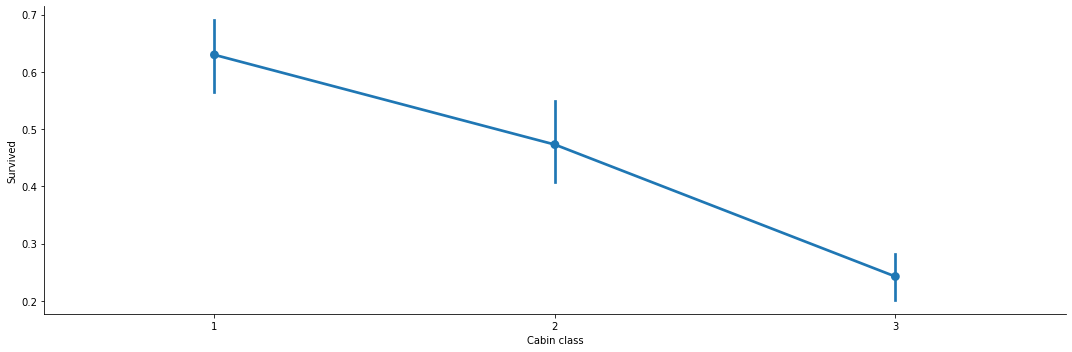

In [3]:
sns.catplot('Pclass', 'Survived', data=train_set, aspect=3, kind="point")
plt.xlabel('Cabin class');

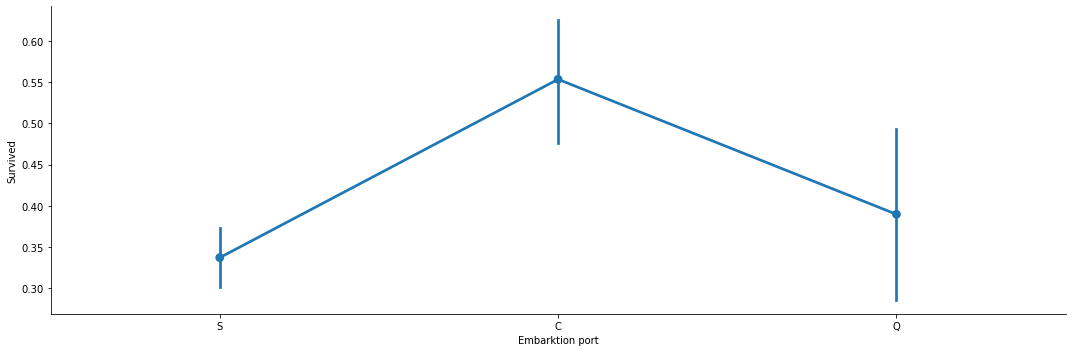

In [4]:
sns.catplot('Embarked', 'Survived', data=train_set, aspect=3, kind="point")
plt.xlabel('Embarktion port');

Also, the port where passengers embarked the ship has a big impact on the survival rate - passengers that went aboard in Cherbourg had statistically higher chances of survival.

Comparing the correlation between the cabin class and survival rate is probably the most interesting bit. It is not a surprise that the higher class passenger had, the higher the chances of survival were.

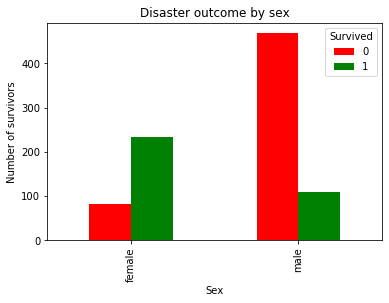

In [5]:
sex_survival_rate = train_set.groupby(['Sex', 'Survived']).size().unstack()
sex_survival_rate.plot(kind='bar', title='Disaster outcome by sex', color=['red', 'green'])
plt.ylabel('Number of survivors');

The vast majority of victims were males that did not survive the tragedy. The highest amount of victims that survived the tragedy were females.

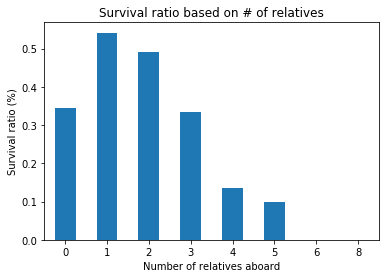

In [6]:
sibsp_survived = train_set.groupby(['SibSp'])['Survived']
parch_survived = train_set.groupby(['Parch'])['Survived']
sibsp_survival_rate = sibsp_survived.sum().fillna(sibsp_survived.mean())
parch_survival_rate = parch_survived.sum().fillna(parch_survived.mean())
relatives_survived_num = sibsp_survival_rate.add(parch_survival_rate, fill_value=0)

sibsp_survival_num = sibsp_survived.count().fillna(sibsp_survived.mean())
parch_survival_num = parch_survived.count().fillna(parch_survived.mean())
relatives_total_num = sibsp_survival_num.add(parch_survival_num, fill_value=0)

(relatives_survived_num / relatives_total_num).plot(kind='bar')
plt.xlabel('Number of relatives aboard')
plt.xticks(rotation=0)
plt.ylabel('Survival ratio (%)')
plt.title('Survival ratio based on # of relatives');

In the above chart the number of siblings and parents of the passengers has been summed and compared to number of people that survived the tragedy.

The highest chances of surviving had people with one relative on board, the second highest chances had people with 2 relatives on-board. People with no or 3 relatives had statistically same chances of surviving.

Finally, the lowest chances of surviving had passengers with 4 or more relatives on board.

## Preparing data

### Introduction


Significant amount of columns contain categorical/enum values - i.e. code of type string that has specific meaning. Whereas it might be helpful for human, it makes the computation unnecessarily expensive. In the following section, dataset will be prepared for later analysis.

### Transformation pipeline

Specifically:

1. Id should be removed as not relevant for training purposes

2. N/A/Empty values should be populated to avoid mathematical operations on empty cells/null data

3. Discrete columns should be transformed

4. Title should be extracted from the name and transformed to discrete value

5. Number of relatives should be summed to construct one column instead of two

6. New boolean feature to construct - Birkenhead Drill - i.e. 'Ladies and children first'

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from titanic_classification.title_selector import TitleSelector
from titanic_classification.relatives_column_creator import RelativesColumnCreator
from titanic_classification.dataframe_simple_imputer import DataFrameSimpleImputer
from titanic_classification.label_remover import LabelRemover
from titanic_classification.age_imputer import AgeImputer
from titanic_classification.birkenhead_drill import BirkenheadDrill
from sklearn.preprocessing import OneHotEncoder

discrete_columns = ['Sex', 'Embarked', 'Title', 'BirkenheadDrill']
num_columns = ['PassengerId', 'Age', 'SibSp', 'Parch', 'Fare']
txt_columns = ['Name', 'Ticket', 'Cabin']

txt_pipeline = Pipeline([
    ('id_rmv', LabelRemover(txt_columns))
])

num_pipeline = Pipeline([
    ('id_rmv', LabelRemover(['PassengerId'])),
    ('imputer', DataFrameSimpleImputer({'strategy':"median"})),
    ('relatives_creator', RelativesColumnCreator()),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', DataFrameSimpleImputer({'strategy':"most_frequent"})),
    ('vectorizer', OneHotEncoder())
])

col_pipeline = ColumnTransformer(
    remainder='passthrough',
    transformers = [
        ('txt', txt_pipeline, txt_columns),
        ('num', num_pipeline, num_columns),
        ('cat', cat_pipeline, discrete_columns)
    ])

prep_pipeline = Pipeline(steps=[
    ('title_selector', TitleSelector()),
    ('birkenhead_drill', BirkenheadDrill()),
    ('age_imputer', AgeImputer(convert_to_bins=True)),
    ('preprocessor', col_pipeline)
])

### Transforming data

In [29]:
train_set_unlabelled = train_set.drop(columns='Survived')

prep_train_set = prep_pipeline.fit_transform(train_set_unlabelled)
print(f'Size of prepared train set: {np.shape(prep_train_set)}')

Size of prepared train set: (891, 17)


## Machine learning models

### Introduction

After careful data preparation, number of ML models can be used to train using the prepared training data set.

Accordingly to lunch free theorem there is no one perfect model that will serve the purpose perfectly. Rather one need to check multiple solution and select the most promising one.

### Preparation

In [30]:
from sklearn.model_selection import train_test_split


train_label = train_set['Survived']
X_train, X_test, Y_train, Y_test = train_test_split(prep_train_set, train_label, test_size=0.2, random_state=42)
print(f'''
Size of train set: {np.shape(X_train)}
Size of test set: {np.shape(X_test)}
Size of train label vector: {np.shape(Y_train)}
Size of test label vector: {np.shape(Y_test)}
''')


Size of train set: (712, 17)
Size of test set: (179, 17)
Size of train label vector: (712,)
Size of test label vector: (179,)



### Models comparison

                    Classifier  Accurracy   CV Mean     Score
6       RandomForestClassifier   0.849162  0.794957  0.983146
8   GradientBoostingClassifier   0.826816  0.813159  0.905899
4              RidgeClassifier   0.821229  0.831419  0.835674
5            RidgeClassifierCV   0.821229  0.831429  0.835674
0                SGDClassifier   0.815642  0.732966  0.821629
1           LogisticRegression   0.815642  0.824426  0.841292
2         LogisticRegressionCV   0.815642  0.831429  0.839888
7           AdaBoostClassifier   0.810056  0.820191  0.849719
3  PassiveAggressiveClassifier   0.804469  0.747306  0.789326


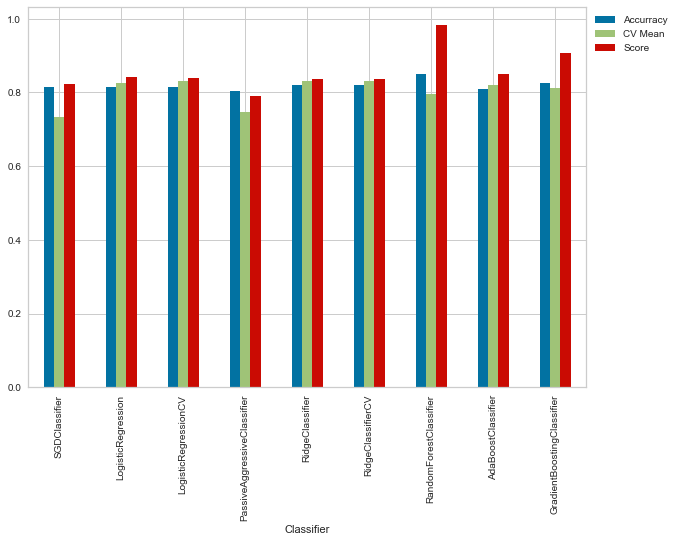

In [31]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from pandas import DataFrame

classifiers = {
    'SGDClassifier': SGDClassifier(),
    'LogisticRegression': LogisticRegression(),
    'LogisticRegressionCV': LogisticRegressionCV(),
    'PassiveAggressiveClassifier': PassiveAggressiveClassifier(),
    "RidgeClassifier": RidgeClassifier(),
    'RidgeClassifierCV': RidgeClassifierCV(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier()
}

columns = ['Classifier', 'Accurracy', 'CV Mean', 'Score']
df_scores = DataFrame(columns=columns)

for name, clf in classifiers.items():
    clf.fit(X_train, Y_train)
    Y_predicted = clf.predict(X_test)
    acc_score = accuracy_score(Y_test, Y_predicted)
    cv_mean = np.mean(cross_val_score(clf, X_train, Y_train, cv=5))
    df_row = DataFrame([[name, acc_score, cv_mean, clf.score(X_train, Y_train)]],columns=columns)
    df_scores = df_scores.append(df_row, ignore_index=True)

print(df_scores.sort_values('Accurracy', ascending=False))
df_scores.plot.bar(x='Classifier', figsize=(10,7)).legend(bbox_to_anchor=(1, 1));

The highest overall score was achieved by Random Forest Classifier with 0.98, accuracy of 0.84 and CV mean equal to 0.79.

The next, most promising classifiers were Logistic Regression Classifier and Gradient Boosting Classifier.

### Misclassification analysis

In [11]:
Y_predicted = classifiers['RandomForestClassifier'].predict(X_test)
misclassified_indices = Y_test[Y_test != Y_predicted].index
wrongly_predicted = train_set.iloc[[*misclassified_indices]]
wrongly_predicted['Predicted'] = 1 - wrongly_predicted['Survived']
wrongly_predicted.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Predicted
621,622,1,1,"Kimball, Mr. Edwin Nelson Jr",male,42.0,1,0,11753,52.5542,D19,S,0
447,448,1,1,"Seward, Mr. Frederic Kimber",male,34.0,0,0,113794,26.5500,NaN,S,0
192,193,1,3,"Andersen-Jensen, Miss. Carla Christine Nielsine",female,19.0,1,0,350046,7.8542,NaN,S,0
793,794,0,1,"Hoyt, Mr. William Fisher",male,NaN,0,0,PC 17600,30.6958,NaN,C,1
235,236,0,3,"Harknett, Miss. Alice Phoebe",female,NaN,0,0,W./C. 6609,7.5500,NaN,S,1


The model makes some mistakes in its predictions, but there cases where the misclassification outcome is understandable.

[Hoyt, Mr. William Fisher](https://www.encyclopedia-titanica.org/titanic-victim/william-fisher-hoyt.html) was allocated a first class cabin, he was traveling alone and eventually got into lifeboat 14 where he died.

[Harknett, Miss. Alice Phoebe](https://www.encyclopedia-titanica.org/titanic-victim/alice-phoebe-harknett.html) was a lady that embarked the ship in Southampton so she had higher chances of surviving.

Statistically, both men should survive.

## Learning Curve

### Random Forest

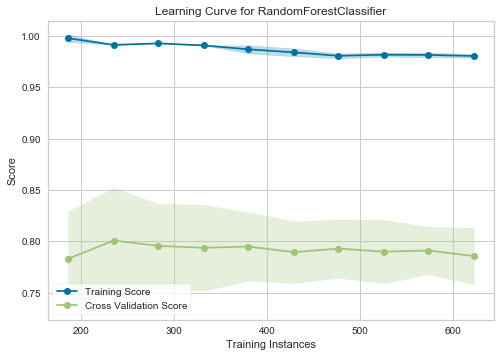

In [12]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve


rf_clf = RandomForestClassifier()
sizes = np.linspace(0.3, 1.0, 10)
cv = StratifiedKFold(n_splits=8)

visualizer = LearningCurve(rf_clf, cv=cv, scoring='f1_weighted', train_sizes=sizes)
visualizer.fit(X_train, Y_train)
visualizer.show();

Learning curve for Random Forest Classifier might look like it is not performing better over time, but in fact it does not make too much sense doing learning curve check for RFC. The training data goes through the same paths all the time, so although the plot might suggest underfitting the classifier performs correctly. 

### Gradient Boosting

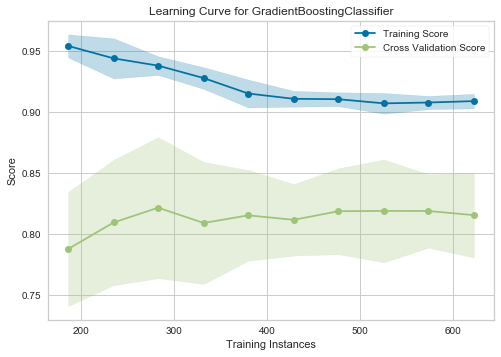

In [13]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve


gb_clf = GradientBoostingClassifier()
sizes = np.linspace(0.3, 1.0, 10)
cv = StratifiedKFold(n_splits=8)

visualizer = LearningCurve(gb_clf, cv=cv, scoring='f1_weighted', train_sizes=sizes)
visualizer.fit(X_train, Y_train)
visualizer.show();

Learning curve graph for Gradient Boosting Classifier shows the overall improvement over time. The algorithm converges until about 600 dataset example and then remains steady. Adding more training examples would not improve the overall performance.

### ADA Boost Classifier

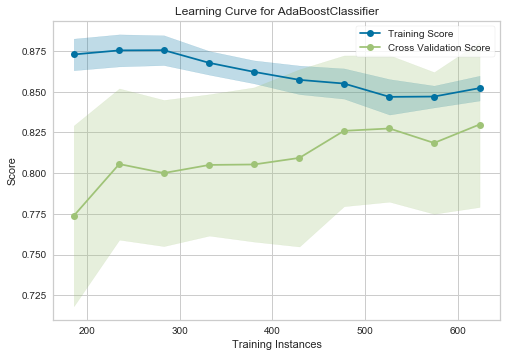

In [14]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve


ab_clf = AdaBoostClassifier()
sizes = np.linspace(0.3, 1.0, 10)
cv = StratifiedKFold(n_splits=8)

visualizer = LearningCurve(ab_clf, cv=cv, scoring='f1_weighted', train_sizes=sizes)
visualizer.fit(X_train, Y_train)
visualizer.show();

Learning curve graph for ADA Boost Classifier looks even better than the previous one - the classifier is learning up to ~520 training set and then converges. The plot suggest that similarly to previous classifiers adding more training examples would not help.

### Random Forest Classifier tuning

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


rf_clf = RandomForestClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'n_estimators': [250, 280, 300, 500, 1000],
    'class_weight': ['balanced', 'balanced_subsample', None],
    'ccp_alpha': [0, .001, .002]
}
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, Y_train)

best_rf_clf = grid_search.best_estimator_
best_rf_params = grid_search.best_params_
Y_predicted = best_rf_clf.predict(X_test)
print(classification_report(Y_test, Y_predicted))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       105
           1       0.82      0.73      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



### Logistic Regression Classifier tuning

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


lg_clf = LogisticRegression()
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear'],
    'class_weight': ['balanced'],
    'intercept_scaling': [1, 1.5, 3, 5, 10],
    'C': [1, 1.5, 3, 5, 10],
    'multi_class': ['auto', 'ovr']
}
grid_search = GridSearchCV(estimator=lg_clf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, Y_train)

best_lg_clf = grid_search.best_estimator_
best_lg_params = grid_search.best_params_
Y_predicted = best_lg_clf.predict(X_test)
print(classification_report(Y_test, Y_predicted))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83       105
           1       0.74      0.81      0.77        74

    accuracy                           0.80       179
   macro avg       0.80      0.81      0.80       179
weighted avg       0.81      0.80      0.81       179



### Gradient Boosting Classifier tuning

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


gb_clf = GradientBoostingClassifier()
param_grid = {
    'loss': ['deviance', 'exponential'],
    'learning_rate': [.1, .2, .5, 1, 1.3]
}
grid_search = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, Y_train)

best_gb_clf = grid_search.best_estimator_
best_gb_params = grid_search.best_params_
Y_predicted = best_gb_clf.predict(X_test)
print(classification_report(Y_test, Y_predicted))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84       105
           1       0.77      0.81      0.79        74

    accuracy                           0.82       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.82      0.82      0.82       179



After fitting hyper-parameters it looks like the Random Forest Classifier with Logistic Regression Classifier performs the best achieving approximately 84% - 87% precision and 82% - 83% accuracy.

## Submission

### Introduction

As part of the competition, Kaggle provides test csv file that should be used to generate csv file with 2 columns - PassengerId and survival outcome.

The following code will save the csv file to /submission folder that is excluded from git tracking.

In [23]:
from titanic_classification.load_data import load_data


test_set = load_data('./dataset', 'test.csv', keep_na=True)
test_set.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Preparation

In [24]:
best_new_rf_clf = RandomForestClassifier(**best_rf_params)
best_new_rf_clf.fit(prep_train_set, train_label)

prep_test_set = prep_pipeline.fit_transform(test_set)

### Prediction

In [25]:
test_Y_predicted = best_new_rf_clf.predict(prep_test_set)

### Submission

In [26]:
import pandas as pd


predicted_survivors = pd.DataFrame({
    'PassengerId': test_set['PassengerId'],
    'Survived': test_Y_predicted
})

predicted_survivors.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


### Saving / Exporting

In [27]:
from titanic_classification.export_csv import export_csv


export_csv(predicted_survivors, './submission')